In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 讀取 libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
%matplotlib inline
import cv2

import os
# 設定當前工作目錄
path="/content/drive/MyDrive/wafer/"
os.chdir(path)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 讀取資料(pkl檔)
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
# 刪除原先的index
df = df.drop(['waferIndex'], axis = 1)

In [ ]:
# 算出晶圓的長寬，並儲存至新欄位 waferMapDim
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0,dim1
df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
629268,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot39581,[],[],"(25, 27)"
106460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",845.0,lot7248,[],[],"(35, 31)"
306492,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot18667,[],[],"(44, 44)"
354367,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2582.0,lot21156,[],[],"(59, 56)"
472466,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29089,[],[],"(49, 39)"


In [ ]:
# 將 failureType 和 trianTestLabel 欄位名稱改為 failureNum 和 trainTestNum
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trianTestLabel
# 將 failureNum 和 trainTestNum 兩個欄位內容轉為數字代碼
mapping_type = {'Center':0,
         'Donut':1,
         'Edge-Loc':2,
         'Edge-Ring':3,
         'Loc':4,
         'Random':5,
         'Scratch':6,
         'Near-full':7,
         'none':8} # none = 無缺陷
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
# 從原始資料取出 8 種缺陷類型的晶圓資料
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
# 重設 index
df_withpattern = df_withpattern.reset_index()
# 刪除後續沒有用到的欄位 dieSize 和 lotName
df_withpattern = df_withpattern.drop(columns=['dieSize', 'lotName'])

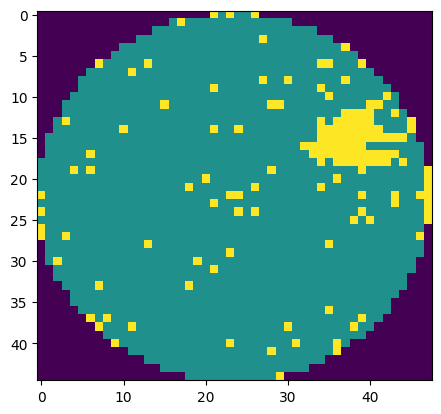

In [ ]:
# 第一張晶圓缺陷圖呈現(缺陷種類: Loc)
plt.imshow(df_withpattern.waferMap[0])
plt.show()

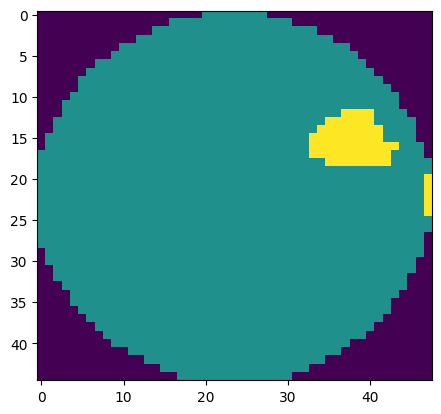

In [ ]:
# 經過中值濾波器(median filter)降噪後的第一張晶圓缺陷圖呈現
plt.imshow(cv2.medianBlur(df_withpattern.waferMap[0], 3))
plt.show()

In [ ]:
# 將資料複製一份到新變數 df_labeled
df_labeled = df_withpattern.copy()
# 取出晶圓陣列資料
X = df_labeled['waferMap'].values
# 取出缺陷種類欄位的內容，並轉換為 float 32 位元型態，接著利用 to_categorical 將類別向量 y 轉換為二進位的矩陣向量(One-hot encoding 技術，以 0 和 1 區分標籤類別)
y = np.array(df_labeled['failureNum']).astype('float32') # astype 適用於 numpy 中資料型態的轉換
y = to_categorical(y, num_classes=8)

In [ ]:
# 將每張圖片利用中值濾波器去除影像雜訊，並存到 X_copy
X_copy = [ ]

for i in range(X.shape[0]):
  img = cv2.medianBlur(X[i], 3)
  X_copy.append(img)

X_copy = np.array(X_copy)

In [ ]:
# 將每張圖片大小設定為 64 x 64
X_copy_v2 = np.array([cv2.resize(img, dsize=(64,64)) for img in X_copy])

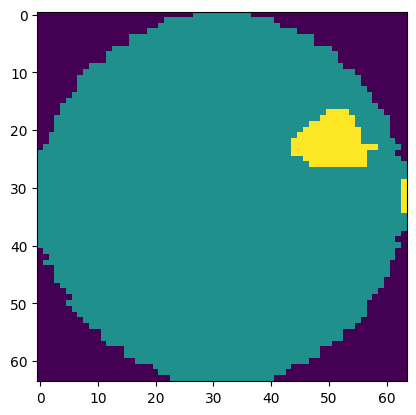

In [ ]:
# 降噪後的晶圓缺陷圖 (種類:Loc, 大小: 64 x 64)
plt.imshow(X_copy_v2[0])
plt.show()

In [ ]:
# 每張圖片轉換為三維空間大小
# (注意: 第三維的數值為 1，目前還不能填 3，否則會因為無法從原先 64 x 64 的維度拆解為 64 x 64 x 3而出現 error)
X_copy_v2 = X_copy_v2.reshape((-1, 64, 64, 1))

In [ ]:
# 根據 Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University[http://dsba.korea.ac.kr/main] 的方法
# Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty.
# Extend extra dimension with one-hot-encoded categorical data as channel.
new_X_copy = np.zeros((len(X_copy_v2), 64, 64, 3))

for w in range(len(X_copy_v2)):
  for i in range(64):
    for j in range(64):
      new_X_copy[w, i, j, int(X_copy_v2[w, i, j])] = 1

In [ ]:
# 轉換為 float 32 位元型態
new_X_copy = new_X_copy.astype('float32')

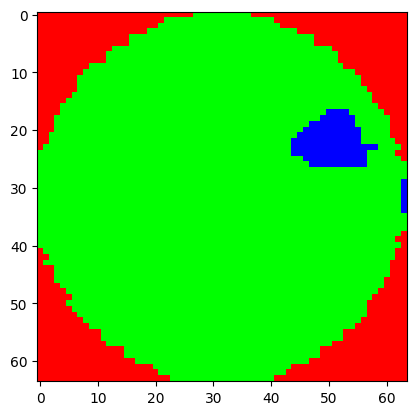

In [ ]:
plt.imshow(new_X_copy[0])
plt.show()

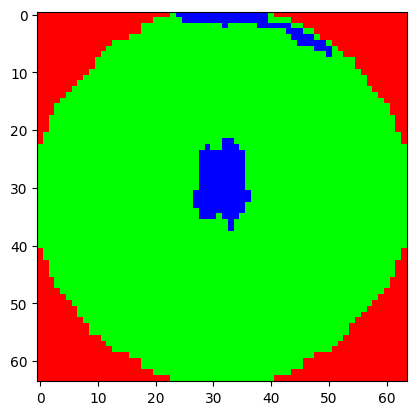

In [ ]:
plt.imshow(new_X_copy[df_labeled['failureNum']==0][0])
plt.show()

In [ ]:
# 資料切割 (80% = Train, 20% = Test)
X_train, X_test, y_train, y_test = train_test_split(new_X_copy, y, test_size=0.2, stratify=y, random_state=2021)

In [ ]:
# 儲存資料
# np.savez(os.path.join(path, 'rawdata.npz'), X_data=new_X_copy, y_data=y)
np.savez(os.path.join(path, 'rawdata.npz'), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)